In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver

from SignalAttenuation import Attenuation

In [131]:
site = 'SiteB'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']

def interpData(d,x, DeltaInput=False, DeltaIn=0.):

        if DeltaInput:
            Delta = DeltaIn
        else:
            diff = np.diff(d)
            Delta = round(min(diff), 3)

        d_min = Delta * np.ceil(d[0]/Delta)
        d_max = Delta * np.floor(d[-1]/Delta)

        n = int(1 + (d_max - d_min)/Delta)

        j_arr = np.linspace(0,n,n)
        dhat0 = d_min + (j_arr - 1)*Delta

        f = interpolate.CubicSpline(d,x)

        xhat0 = f(dhat0)

        dhat = dhat0[(dhat0 >= min(d)) & (dhat0 <= max(d))]
        xhat = xhat0[(dhat0 >= min(d)) & (dhat0 <= max(d))]

        return dhat, xhat, Delta



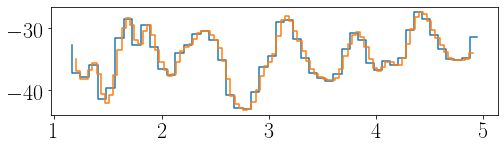

In [132]:
cutOff_High = 0
cutOff_Low = cutOff_High + 5#max(depth)

depthTop = np.asarray(depth[(depth > cutOff_High) & (depth < cutOff_Low)])
d18OTop = np.asarray(d18O[(depth > cutOff_High) & (depth < cutOff_Low)])

DeltaMean = np.mean(np.diff(depthTop))/2

dHat, xHat, Delta = interpData(depthTop, d18OTop, True, DeltaIn = DeltaMean)

fig, ax = plt.subplots(figsize=(8,2))
plt.step(depthTop,d18OTop)
plt.step(dHat, xHat)


In [133]:
AttInst = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'DCT')
dataDCT, keysDCT = AttInst()

AttInst2 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'NDCT')
dataNDCT, keysNDCT = AttInst2()

AttInst3 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'FFT')
dataFFT, keysFFT = AttInst3()

AttInst4 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'MEM')
dataMEM, keysMEM = AttInst4()

#plt.plot(AttInst.w,AttInst.P)
#plt.plot(AttInst2.w,AttInst2.P)
#plt.plot(AttInst3.w,AttInst3.P)
#plt.plot(AttInst4.w,AttInst4.P)


0
0
0
0


In [134]:
wDCT = AttInst.w
PDCT = AttInst.P

wNDCT = AttInst2.w
PNDCT = AttInst2.P

wFFT = AttInst3.w
PFFT = AttInst3.P

wMEM = AttInst4.w
PMEM = AttInst4.P





fkDCT = wDCT[dataDCT[0].astype(int)]
hsDCT = dataDCT[1]


fkNDCT = wNDCT[dataNDCT[0].astype(int)]
hsNDCT = dataNDCT[1]


fkFFT = wFFT[dataFFT[0].astype(int)]
hsFFT = dataFFT[1]



idMEM = signal.find_peaks(PMEM, height=0.025)[0]
fkMEM = dataMEM[0]
PkMEM = dataMEM[1]
hsMEM = PMEM[idMEM]
fkkMEM = wMEM[idMEM]

idMax = np.where(hsMEM == max(hsMEM))[0][0]
fkMax = fkkMEM[idMax]
hMax = hsMEM[idMax]

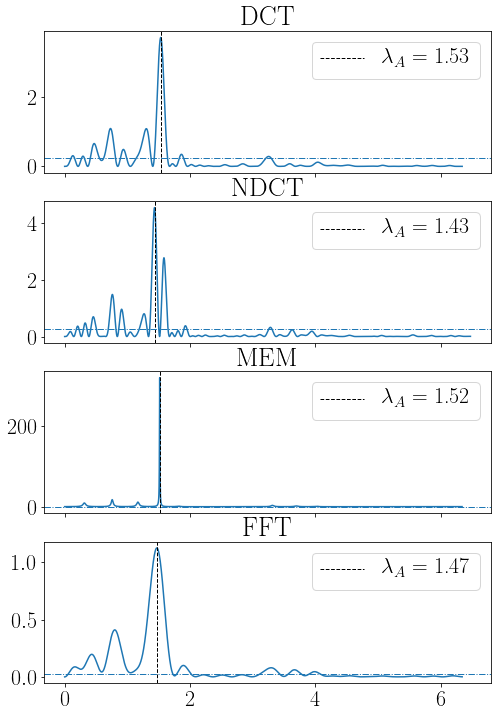

In [135]:
fig, ax = plt.subplots(4,1,figsize=(8,12), sharex=True)

ax[0].plot(wDCT, PDCT)
ax[0].axvline(fkDCT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkDCT[0]:.2f}')
ax[0].set(title='DCT')
ax[0].axhline(0.25,lw=1,ls='-.')
ax[0].legend()

ax[1].plot(wNDCT, PNDCT)
ax[1].axvline(fkNDCT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkNDCT[0]:.2f}')
ax[1].set(title='NDCT')
ax[1].axhline(0.25,lw=1,ls='-.')
ax[1].legend()

ax[2].plot(wMEM, PMEM)
ax[2].axvline(fkMax, lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkMax:.2f}')
ax[2].set(title='MEM')
ax[2].axhline(0.25,lw=1,ls='-.')
ax[2].legend()

ax[3].plot(wFFT, PFFT)
ax[3].axvline(fkFFT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkFFT[0]:.2f}')
ax[3].set(title='FFT')
ax[3].axhline(0.025,lw=1,ls='-.')
ax[3].legend()

#ax[0].set(xlim=(0,4))

In [136]:
depth

1         1.160
2         1.242
3         1.324
4         1.405
5         1.485
         ...   
2316    105.460
2317    105.496
2318    105.532
2319    105.568
2320    105.605
Name: depth, Length: 2320, dtype: float64

In [140]:


vals = np.arange(1,107,5)
vals

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106])

DEPTH:
1 to 6 [m]
0
0
0
0


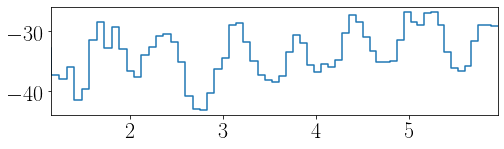

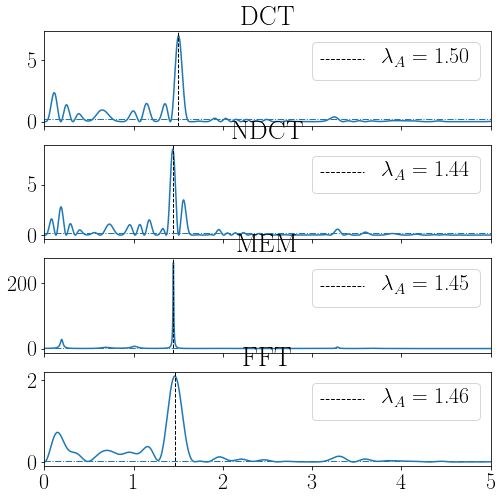

DEPTH:
6 to 11 [m]
1.3025041736227045
1.2395737687813018
1.2607679465776294
1.245847245409015


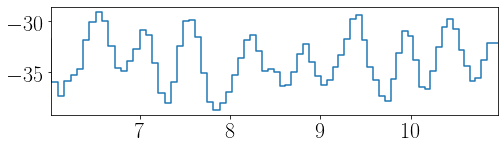

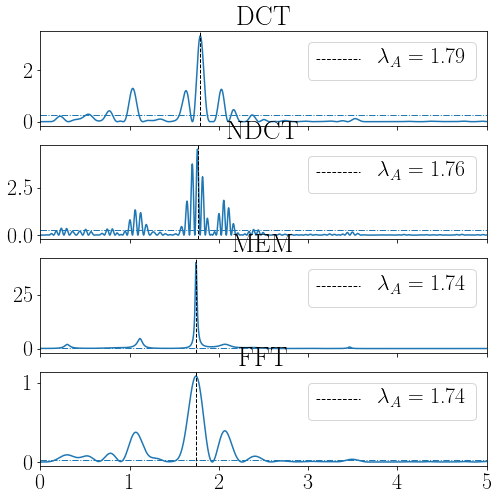

DEPTH:
11 to 16 [m]
1.5916678681551217
1.5613703267736931
1.5431940236472828
1.5441168910715666


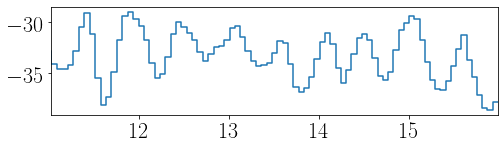

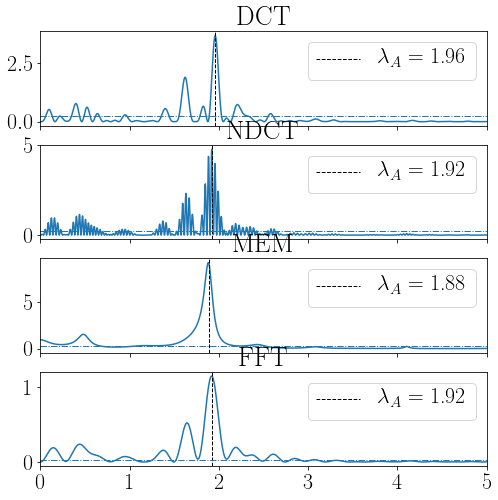

DEPTH:
16 to 21 [m]
1.7584423072963018
1.7217071288656731
1.719314648159993
1.684460141271465


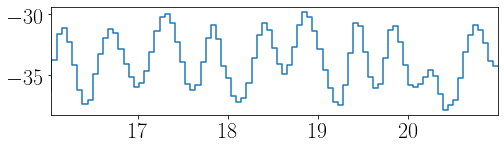

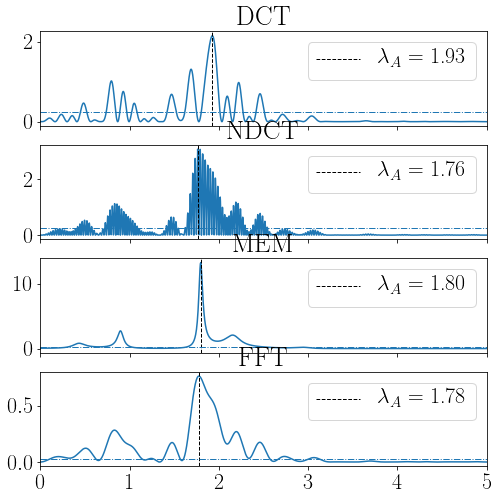

DEPTH:
21 to 26 [m]
1.7284712482468787
1.5631186822922956
1.577261570827521
1.5978830645161608


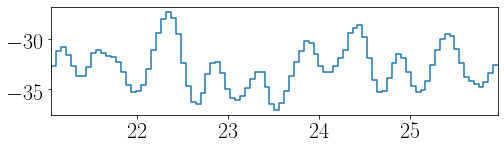

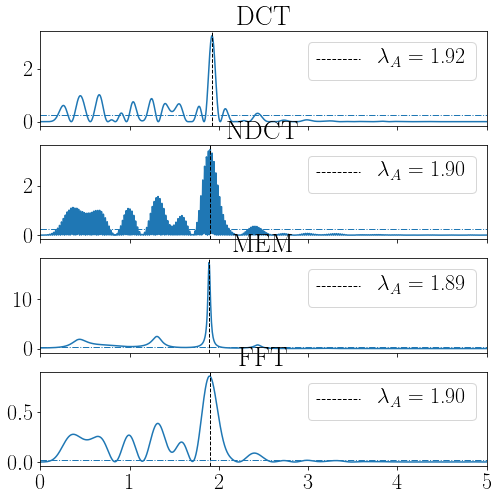

DEPTH:
26 to 31 [m]
1.7242282694954796
1.704601052624808
1.696804588695069
1.6900229409638006


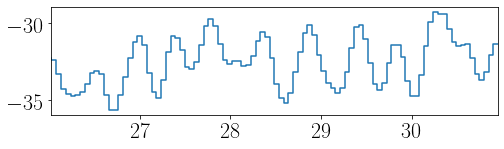

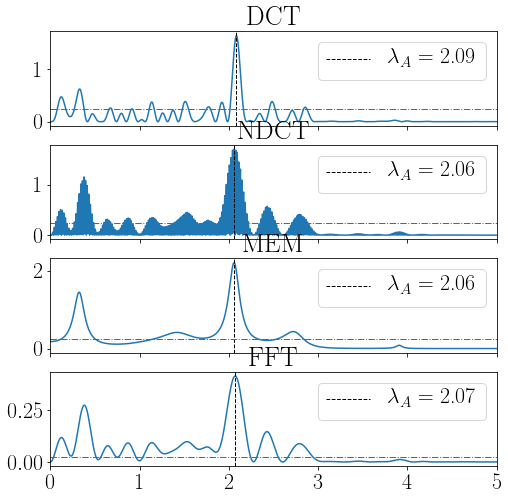

DEPTH:
31 to 36 [m]
1.8853420309203257
1.8578675525799697
1.8713620843443237
1.8594138900040338


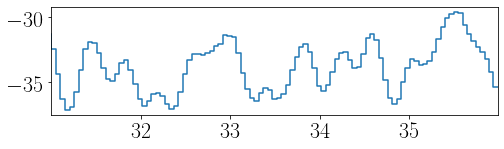

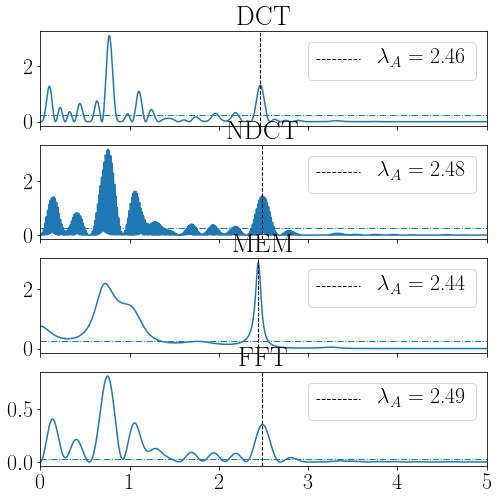

DEPTH:
36 to 41 [m]
2.264154818847419
2.280705075919497
2.288845748895991
2.240520660604927


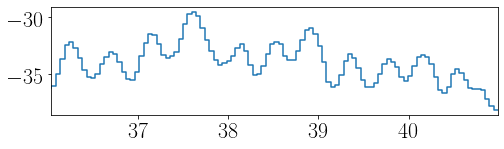

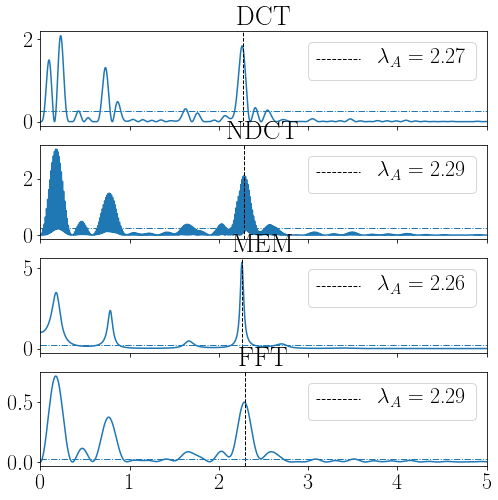

DEPTH:
41 to 46 [m]
2.0656092139824933
2.0859647696444568
2.0908668417860885
2.056819559506842


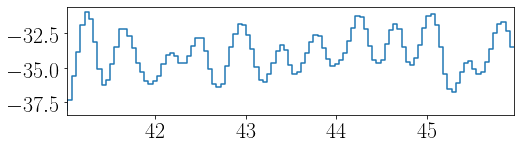

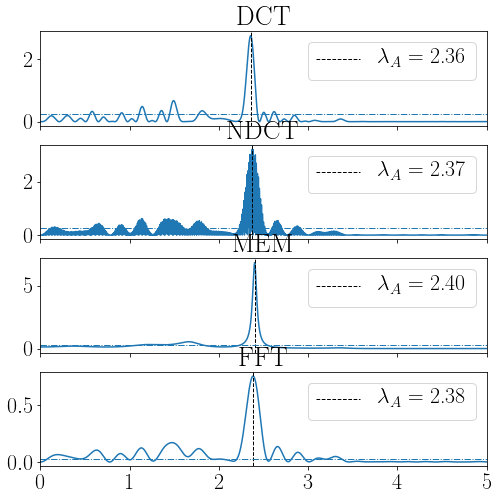

DEPTH:
46 to 51 [m]
2.157507866757847
2.1743223596588406
2.1838193384850553
2.2011849098250127


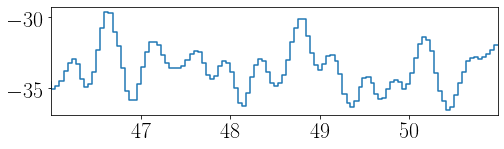

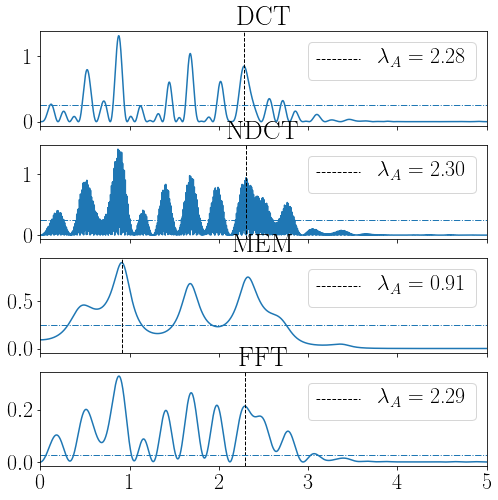

DEPTH:
51 to 56 [m]
2.0813896234156366
2.1028908153030588
2.0923315400747047
0.7101554663991718


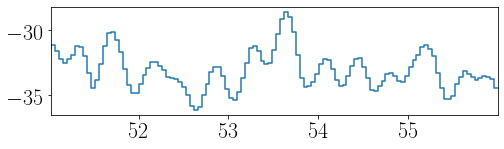

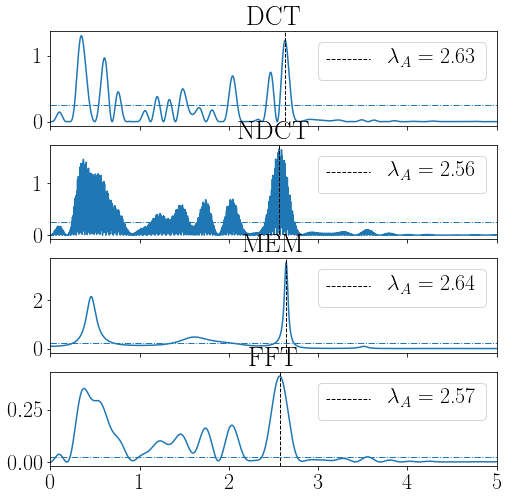

DEPTH:
56 to 61 [m]
2.42898823108252
2.360817284240912
2.37025551528174
2.4395489327426985


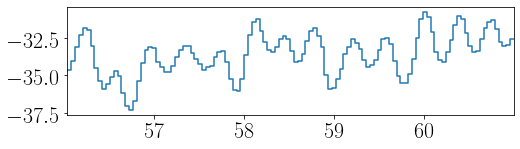

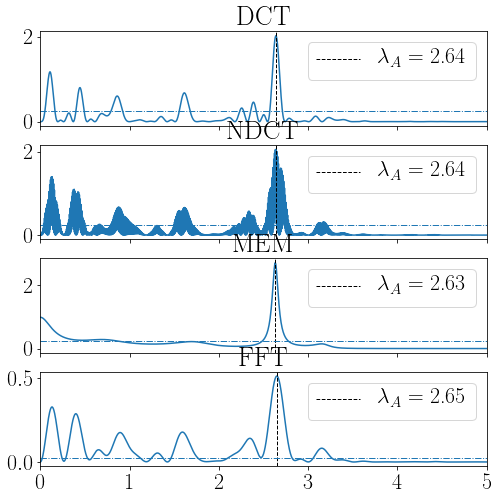

DEPTH:
61 to 66 [m]
2.4398455286897422
2.4415106103919424
2.4513732384220117
2.4326407101070737


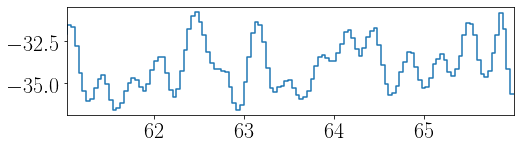

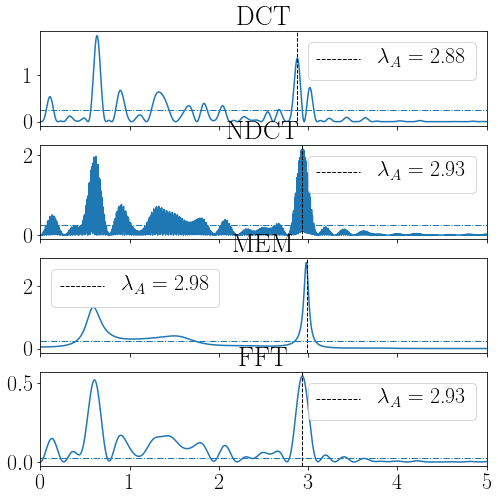

DEPTH:
66 to 71 [m]
2.680930226343252
2.7304032177945685
2.7347793894524717
2.7825914630531137


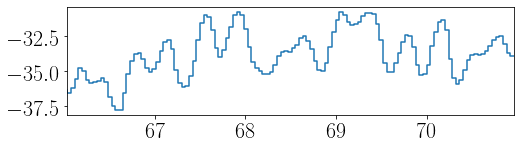

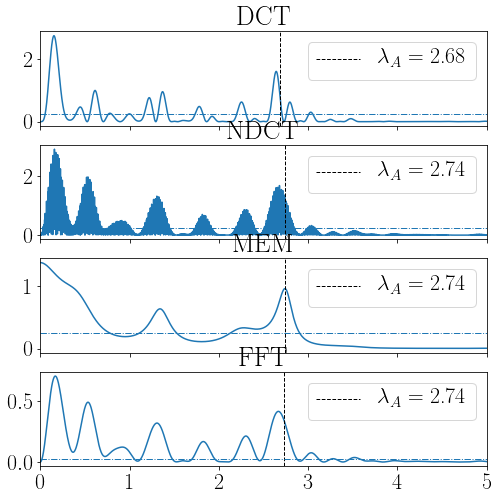

DEPTH:
71 to 76 [m]
2.4813974320689898
2.5371398771671165
2.535144819348769
2.5393908629438715


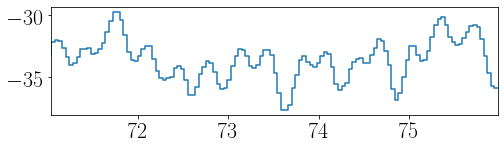

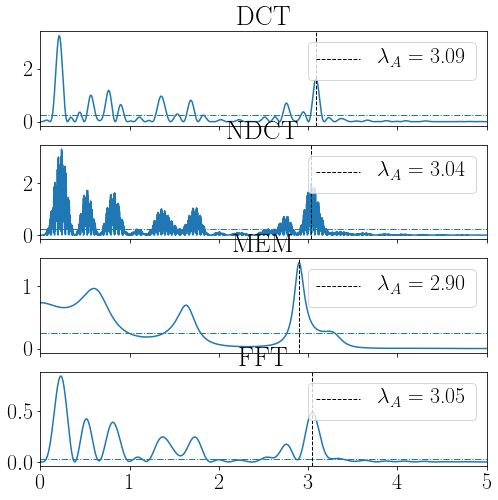

DEPTH:
76 to 81 [m]
2.887328158148973
2.8362121241319986
2.8474718859980928
2.698016997166468


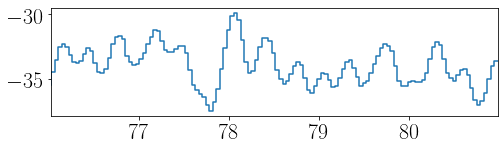

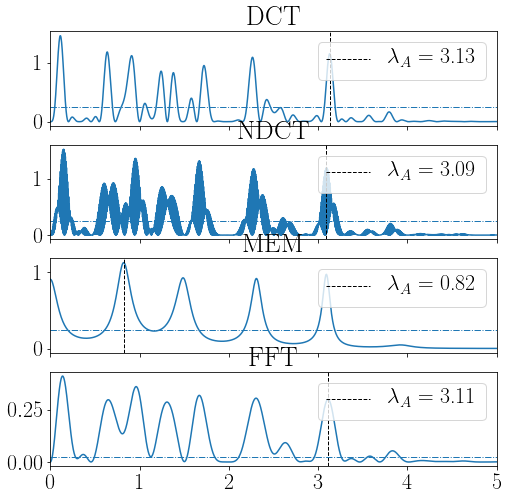

DEPTH:
81 to 86 [m]
2.9312246162427606
2.892038857973686
2.912209082136023
0.6242093103224264


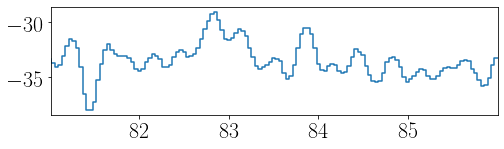

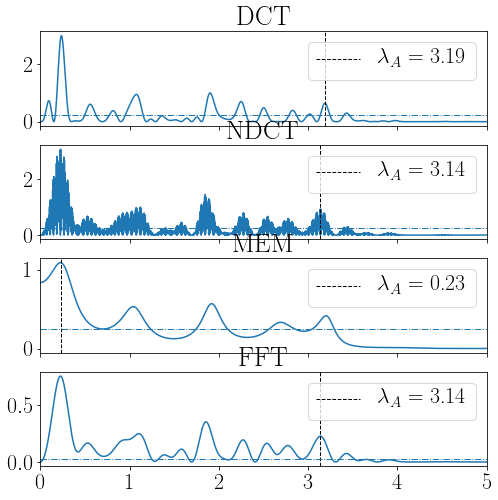

DEPTH:
86 to 91 [m]
2.987281903557783
2.9367070106356388
2.9365391070832314
0.02732772820599194


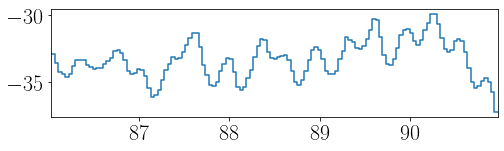

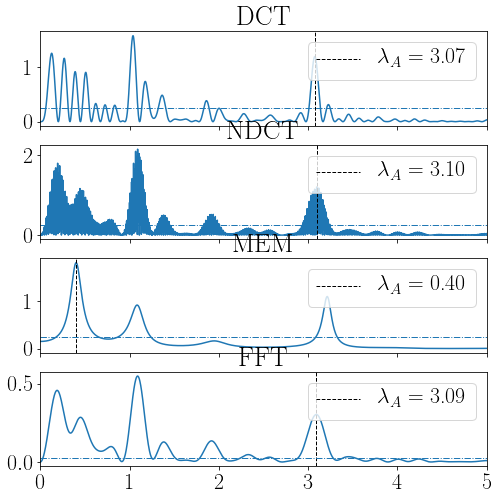

DEPTH:
91 to 96 [m]
2.8740653533214653
2.896214083381512
2.890416764775303
0.20196674776968926


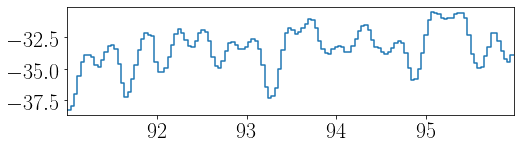

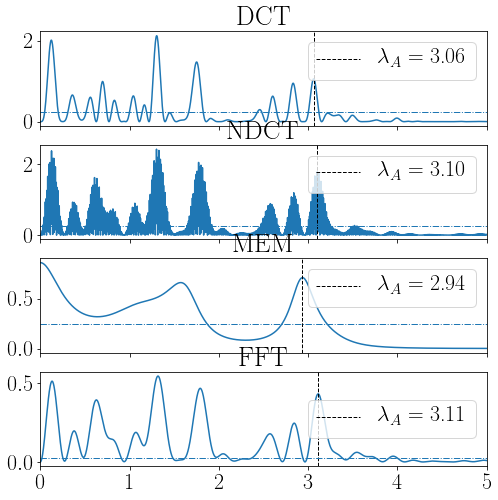

DEPTH:
96 to 101 [m]
2.8634480392463
2.9020594307752203
2.9123849088828226
2.7369951681055262


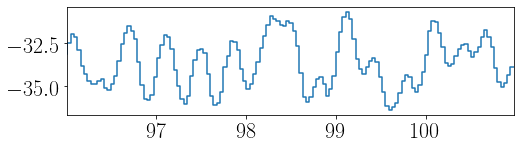

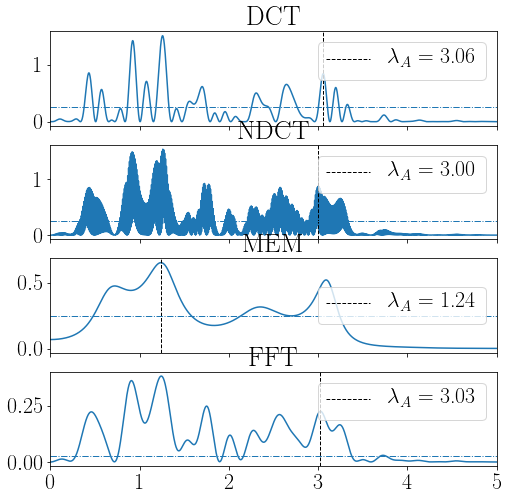

DEPTH:
101 to 106 [m]
2.855358422615616
2.8007468525499744
2.8258855117865265
1.042171849338548


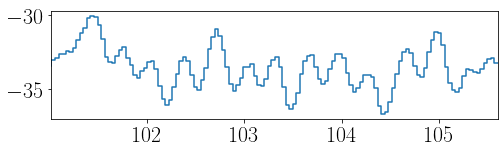

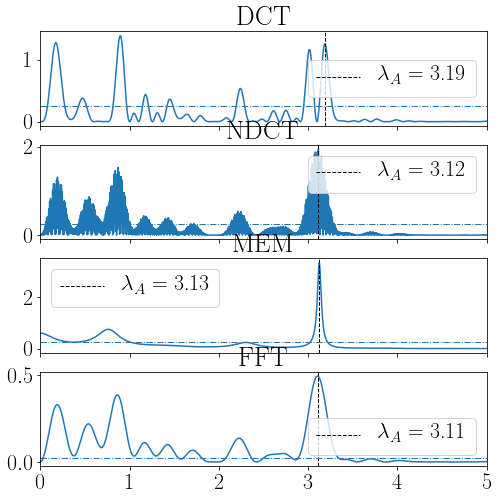

In [141]:
wMinDCT = 0
wMinNDCT = 0
wMinFFT = 0
wMinMEM = 0


fs_all = []

for i in range(len(vals)-1):
    cutOff_High = vals[i]
    cutOff_Low = vals[i+1]#cutOff_High + 5#max(depth)
    
    print('DEPTH:')
    print(f'{cutOff_High} to {cutOff_Low} [m]')
    
    depthTop = np.asarray(depth[(depth > cutOff_High) & (depth < cutOff_Low)])
    d18OTop = np.asarray(d18O[(depth > cutOff_High) & (depth < cutOff_Low)])
    
    #DeltaMean = np.mean(np.diff(depthTop))/2

    #dHat, xHat, Delta = interpData(depthTop, d18OTop, True, DeltaIn = DeltaMean)

    
    fig, ax = plt.subplots(figsize=(8,2))
    ax.step(depthTop,d18OTop)
    #ax.step(dHat, xHat)
    ax.set(xlim=(min(depthTop), max(depthTop)))
    
    
    
    AttInst = Attenuation(depthTop, d18OTop, wMinDCT, PSD_Type = 'DCT')
    dataDCT, keysDCT = AttInst()

    AttInst2 = Attenuation(depthTop, d18OTop, wMinNDCT, PSD_Type = 'NDCT')
    dataNDCT, keysNDCT = AttInst2()

    AttInst3 = Attenuation(depthTop, d18OTop, wMinFFT, PSD_Type = 'FFT')
    dataFFT, keysFFT = AttInst3()

    AttInst4 = Attenuation(depthTop, d18OTop, wMinMEM, PSD_Type = 'MEM')
    dataMEM, keysMEM = AttInst4()


    wDCT = AttInst.w
    PDCT = AttInst.P

    wNDCT = AttInst2.w
    PNDCT = AttInst2.P

    wFFT = AttInst3.w
    PFFT = AttInst3.P

    wMEM = AttInst4.w
    PMEM = AttInst4.P





    fkDCT = wDCT[dataDCT[0].astype(int)]
    hsDCT = dataDCT[1]


    fkNDCT = wNDCT[dataNDCT[0].astype(int)]
    hsNDCT = dataNDCT[1]


    fkFFT = wFFT[dataFFT[0].astype(int)]
    hsFFT = dataFFT[1]



    idMEM = signal.find_peaks(PMEM, height=0.025)[0]
    fkMEM = dataMEM[0]
    PkMEM = dataMEM[1]
    hsMEM = PMEM[idMEM]
    fkkMEM = wMEM[idMEM]

    idMax = np.where(hsMEM == max(hsMEM))[0][0]
    fkMax = fkkMEM[idMax]
    hMax = hsMEM[idMax]


    fig, ax = plt.subplots(4,1,figsize=(8,8), sharex=True)

    ax[0].plot(wDCT, PDCT)
    ax[0].axvline(fkDCT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkDCT[0]:.2f}')
    ax[0].set(title='DCT', xlim=(0,5))
    ax[0].axhline(0.25,lw=1,ls='-.')
    ax[0].legend()

    ax[1].plot(wNDCT, PNDCT)
    ax[1].axvline(fkNDCT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkNDCT[0]:.2f}')
    ax[1].set(title='NDCT', xlim=(0,5))
    ax[1].axhline(0.25,lw=1,ls='-.')
    ax[1].legend()

    ax[2].plot(wMEM, PMEM)
    ax[2].axvline(fkMax, lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkMax:.2f}')
    ax[2].set(title='MEM', xlim=(0,5))
    ax[2].axhline(0.25,lw=1,ls='-.')
    ax[2].legend()

    ax[3].plot(wFFT, PFFT)
    ax[3].axvline(fkFFT[0], lw=1,c='k',ls='--', label=f'$\lambda_A$ = {fkFFT[0]:.2f}')
    ax[3].set(title='FFT', xlim=(0,5))
    ax[3].axhline(0.025,lw=1,ls='-.')
    ax[3].legend()
    plt.show()
    
    wMinDCT = fkDCT[0] - 0.2
    wMinNDCT = fkNDCT[0] - 0.2
    wMinFFT = fkFFT[0] - 0.2
    wMinMEM = fkMax - 0.2
    
    fs = np.asarray([fkDCT[0], fkNDCT[0], fkFFT[0]])
    fs_all.append(fs)

In [142]:
max(depth_LT)
(vals[1:] > min(depth_LT)) & (vals[1:] < max(depth_LT))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False])

In [143]:
fs_all

[array([1.50250417, 1.43957377, 1.46076795]),
 array([1.79166787, 1.76137033, 1.74319402]),
 array([1.95844231, 1.92170713, 1.91931465]),
 array([1.92847125, 1.76311868, 1.77726157]),
 array([1.92422827, 1.90460105, 1.89680459]),
 array([2.08534203, 2.05786755, 2.07136208]),
 array([2.46415482, 2.48070508, 2.48884575]),
 array([2.26560921, 2.28596477, 2.29086684]),
 array([2.35750787, 2.37432236, 2.38381934]),
 array([2.28138962, 2.30289082, 2.29233154]),
 array([2.62898823, 2.56081728, 2.57025552]),
 array([2.63984553, 2.64151061, 2.65137324]),
 array([2.88093023, 2.93040322, 2.93477939]),
 array([2.68139743, 2.73713988, 2.73514482]),
 array([3.08732816, 3.03621212, 3.04747189]),
 array([3.13122462, 3.09203886, 3.11220908]),
 array([3.1872819 , 3.13670701, 3.13653911]),
 array([3.07406535, 3.09621408, 3.09041676]),
 array([3.06344804, 3.10205943, 3.11238491]),
 array([3.05535842, 3.00074685, 3.02588551]),
 array([3.18766347, 3.11526045, 3.10592851])]

In [144]:
ls_all = 1/np.asarray(fs_all)

means = np.mean(ls_all, axis=1)
stds = np.std(ls_all, axis=1)
app = np.mean(means[(vals[1:] > min(depth_LT)) & (vals[1:] < max(depth_LT))])

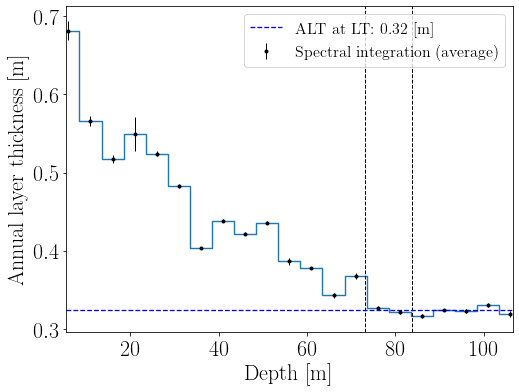

In [145]:
fig, ax = plt.subplots(figsize=(8,6))

ax.step(vals[1:], means, where='mid', lw=1.4)
ax.errorbar(vals[1:], means, stds,c='k', fmt='.', lw=1, label='Spectral integration (average)')
ax.set(xlim=(min(vals[1:])-0.5,max(vals)+0.5), xlabel='Depth [m]', ylabel='Annual layer thickness [m]')
ax.axvline(min(depth_LT), lw=1, ls='--', c='k')
ax.axvline(max(depth_LT), lw=1, ls='--', c='k')
ax.axhline(app, lw=1.3, ls='--', c='b', label = f'ALT at LT: {app:.2f} [m]')

ax.legend(fontsize=16)

In [43]:

test = np.array([1.6025,1.7425,1.9425,2,2.1,2.4967,2.6,2.7,2.72,2.9,3.05,3.2,3.2,3.2,3.33,3.0975,3.25,3.04,3.4,3.5,3.19])

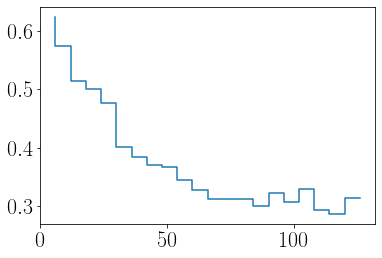

In [48]:
plt.step(vals[1:],1/test)

DEPTH:
0 to 5 [m]


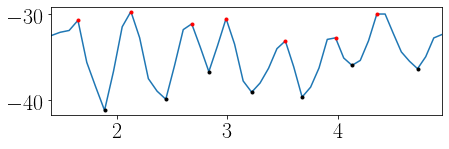

DEPTH:
5 to 10 [m]


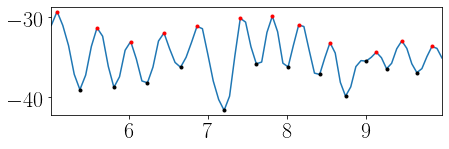

DEPTH:
10 to 15 [m]


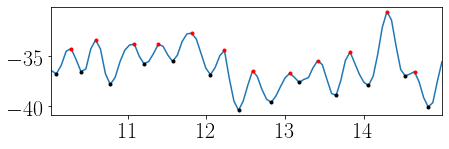

DEPTH:
15 to 20 [m]


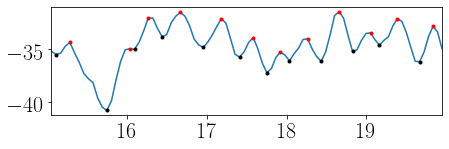

DEPTH:
20 to 25 [m]


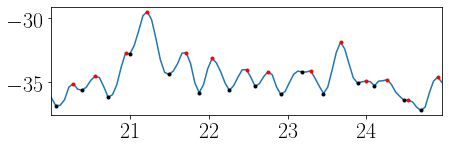

DEPTH:
25 to 30 [m]


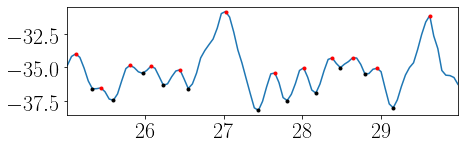

DEPTH:
30 to 35 [m]


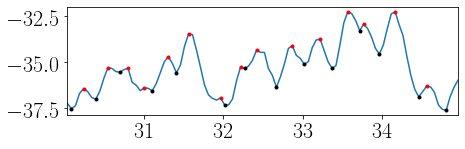

DEPTH:
35 to 40 [m]


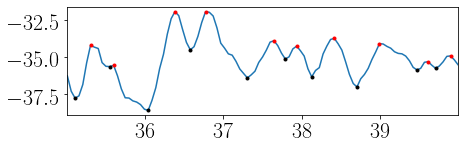

DEPTH:
40 to 45 [m]


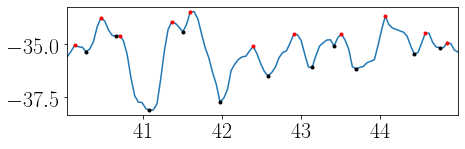

DEPTH:
45 to 50 [m]


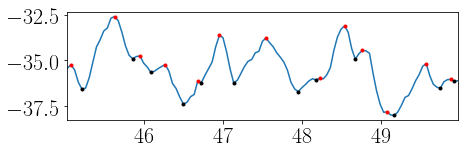

DEPTH:
50 to 55 [m]


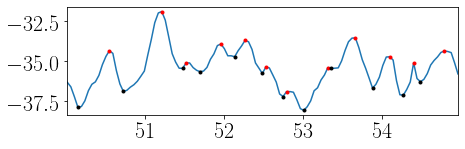

DEPTH:
55 to 60 [m]


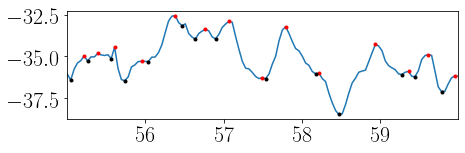

DEPTH:
60 to 65 [m]


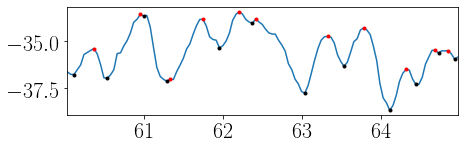

DEPTH:
65 to 70 [m]


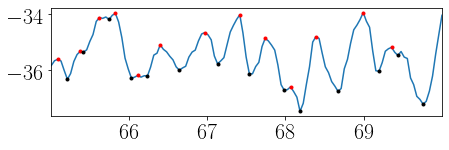

DEPTH:
70 to 75 [m]


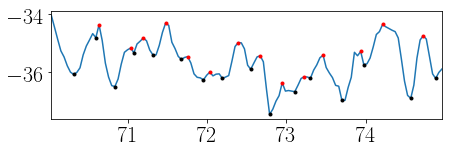

In [51]:
for i in range(len(vals)-1):
    cutOff_High = vals[i]
    cutOff_Low = vals[i+1]#cutOff_High + 5#max(depth)
    
    print('DEPTH:')
    print(f'{cutOff_High} to {cutOff_Low} [m]')
    
    depthTop = np.asarray(depth[(depth > cutOff_High) & (depth < cutOff_Low)])
    d18OTop = np.asarray(d18O[(depth > cutOff_High) & (depth < cutOff_Low)])
    

    peaks, props = signal.find_peaks(d18OTop, distance=4)
    troughs, props2 = signal.find_peaks(-d18OTop, distance=4)


    fig, ax = plt.subplots(figsize=(7,2))
    ax.plot(depthTop, d18OTop)
    ax.plot(depthTop[peaks], d18OTop[peaks],'.',c='r')
    ax.plot(depthTop[troughs], d18OTop[troughs],'.',c='k')
    ax.set(xlim=(min(depthTop), max(depthTop)))
    plt.show()